# Excitatory Neurons

In [1]:
! pip install scanpy
! pip install scProject -U
import scProject
import scanpy as sc

Requirement already up-to-date: scProject in /Users/asherbaraban/opt/anaconda3/lib/python3.7/site-packages (1.0.5)


/Users/asherbaraban/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
patterns = sc.read_h5ad('patterns_anndata.h5ad')
dataset = sc.read_h5ad('test_target.h5ad')
dataset_filtered, patterns_filtered = scProject.matcher.filterAnnDatas(dataset, patterns, 'gene_id')

(55371, 428) dataset filter shape
(80, 428) patterns filter shape


Weight .001 only 1% lasso to encourage as many features to show up. Then, we will increase the lasso and the regularization to see what drops out.

(55371, 80)
[DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, Vascular Endothelium, ..., Cycling Neural Progenitor, Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]
Length: 12
Categories (12, object): [DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, ..., Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]


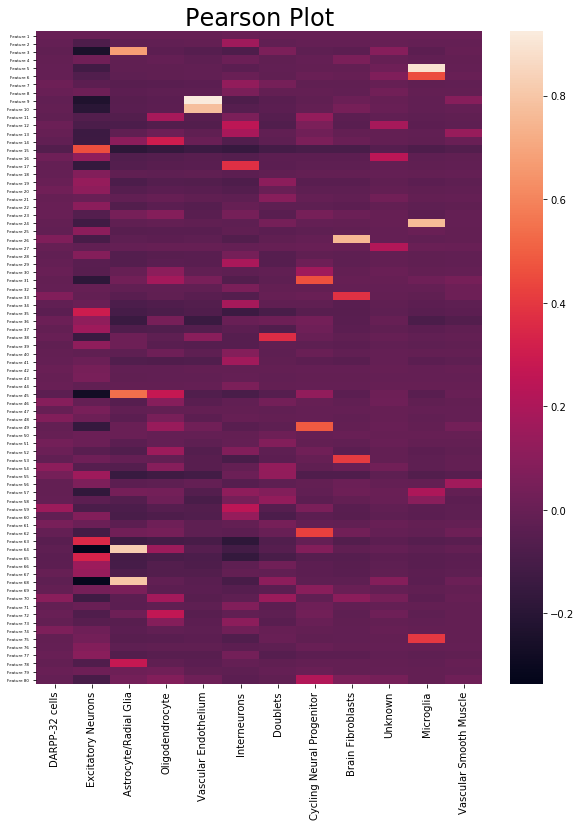

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']= [10, 12]
scProject.rg.NNLR_ElasticNet(dataset_filtered, patterns_filtered, 'EN01', .001, .01)
scProject.viz.pearsonMatrix(dataset_filtered, patterns_filtered, 'CellType', 12, 'EN01', 'PearsonEN01', True)

[DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, Vascular Endothelium, ..., Cycling Neural Progenitor, Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]
Length: 12
Categories (12, object): [DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, ..., Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]


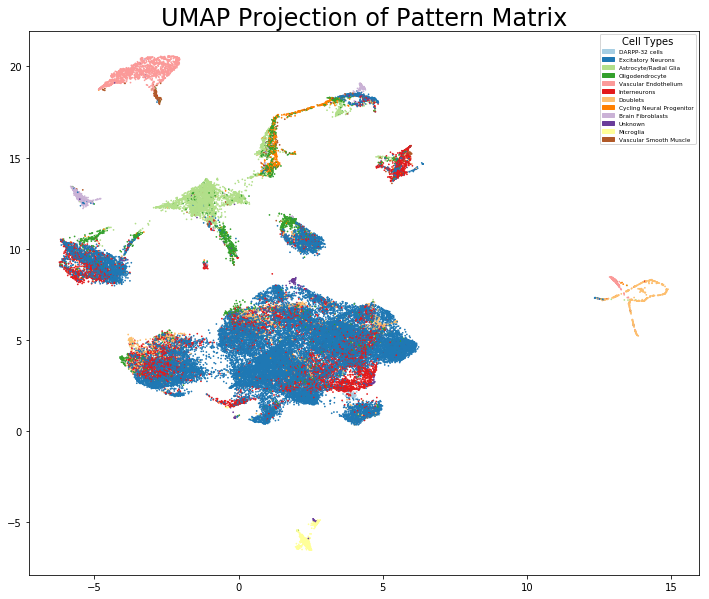

In [4]:
plt.rcParams['figure.figsize']= [12, 10]
scProject.viz.UMAP_Projection(dataset_filtered, 'CellType', 'EN01', 'UMAPEN01', 20)

Since there is so much heterogeneity in excitatory neurons features could have an unimpressive pearson value, but still be a driver of one cluster of excitatory neurons. These features are obviously valuable in uderstanding the sub types of excitatory neurons. While it is annoying to see all of the plots, it is the easiest way to find the interesting ones. For brevity, I condensed it down from the 80 to the interesting ones for this notebook. This is a lot of features so I am going to regress again with a higher lasso to see which ones dropout. There dropout does not mean that they are not important, but rather that they are not the strongest drivers.

Number of nonzero cells 29079
Percentage of nonzero cells 52.516660345668306
Max coefficient 1.4105762
Average coefficient 0.25742006


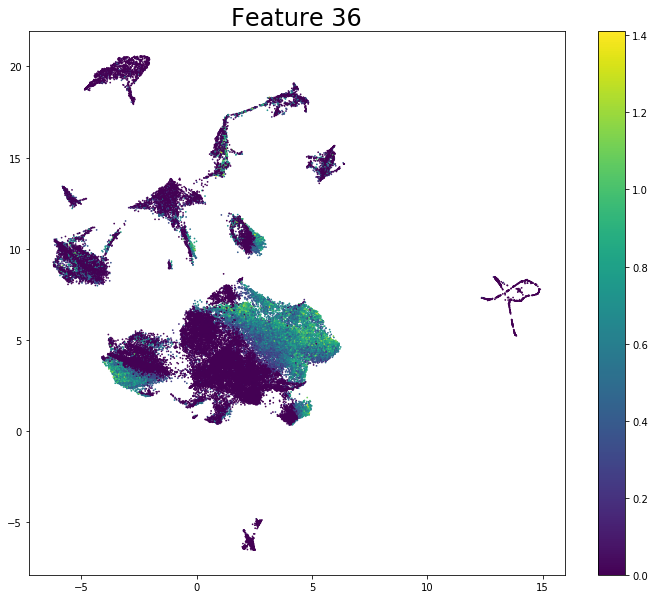

Number of nonzero cells 8451
Percentage of nonzero cells 15.262502031749472
Max coefficient 2.2803771
Average coefficient 0.0479635


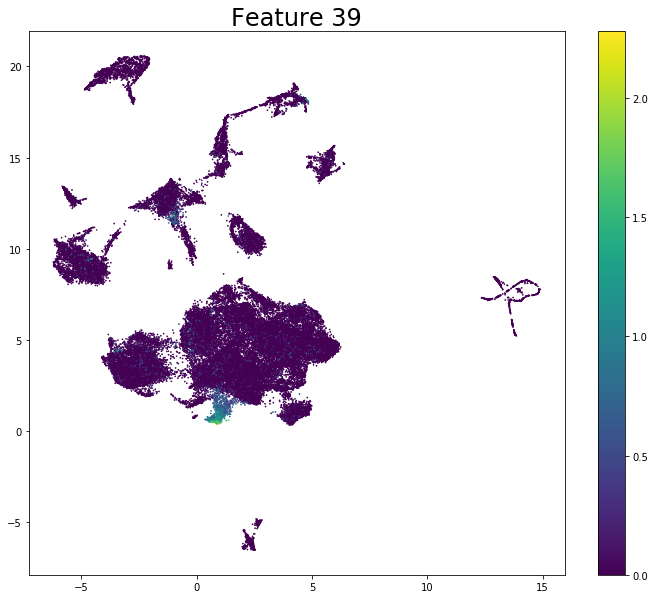

Number of nonzero cells 19177
Percentage of nonzero cells 34.633652995250216
Max coefficient 3.0940485
Average coefficient 0.1760653


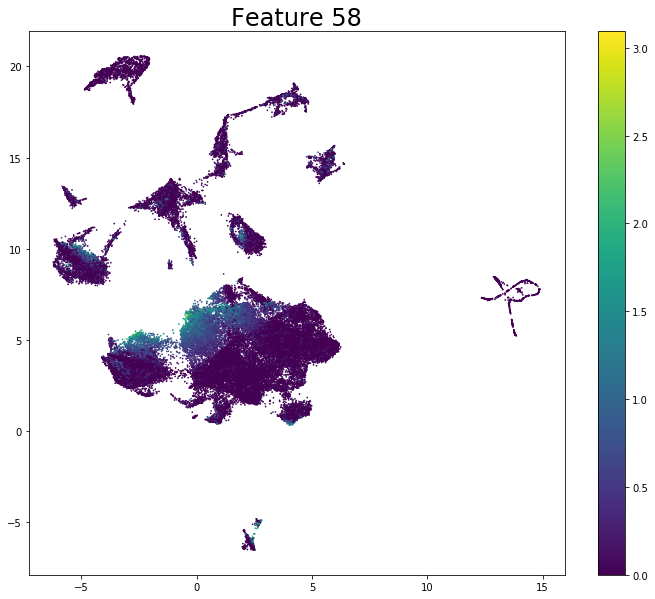

In [5]:
scProject.viz.featurePlots(dataset_filtered, [36, 39, 58], 'EN01', 'UMAPEN01')

While the other features are lighting up some sub types of excitatory neurons feature 36 looks really interesting because it only lights up half of each cluster it is expressed in. Next, I am going to up the lasso to 75% to see which features are the strongest drivers.

(55371, 80)
[DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, Vascular Endothelium, ..., Cycling Neural Progenitor, Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]
Length: 12
Categories (12, object): [DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, ..., Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]


/Users/asherbaraban/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


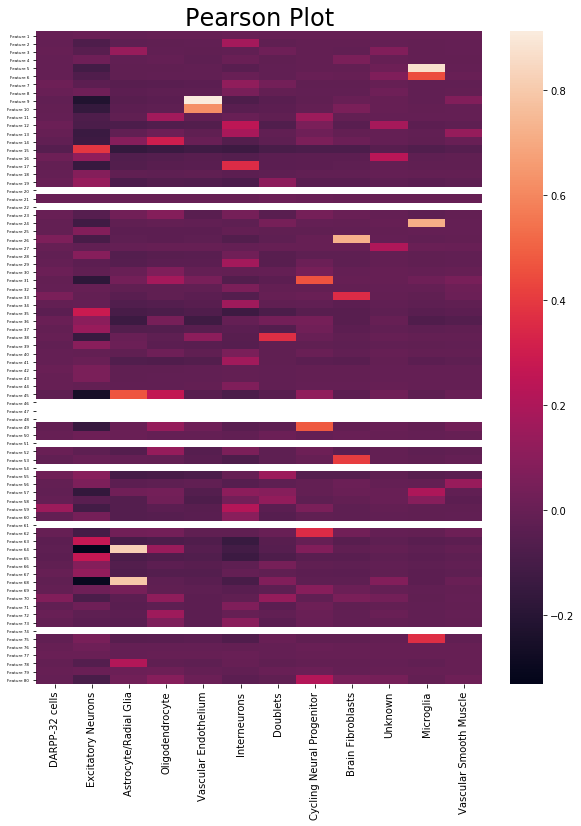

In [6]:
plt.rcParams['figure.figsize']= [10, 12]
scProject.rg.NNLR_ElasticNet(dataset_filtered, patterns_filtered, 'EN60', .001, .75)
scProject.viz.pearsonMatrix(dataset_filtered, patterns_filtered, 'CellType', 12, 'EN60', 'PearsonEN60', True)

[DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, Vascular Endothelium, ..., Cycling Neural Progenitor, Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]
Length: 12
Categories (12, object): [DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, ..., Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]


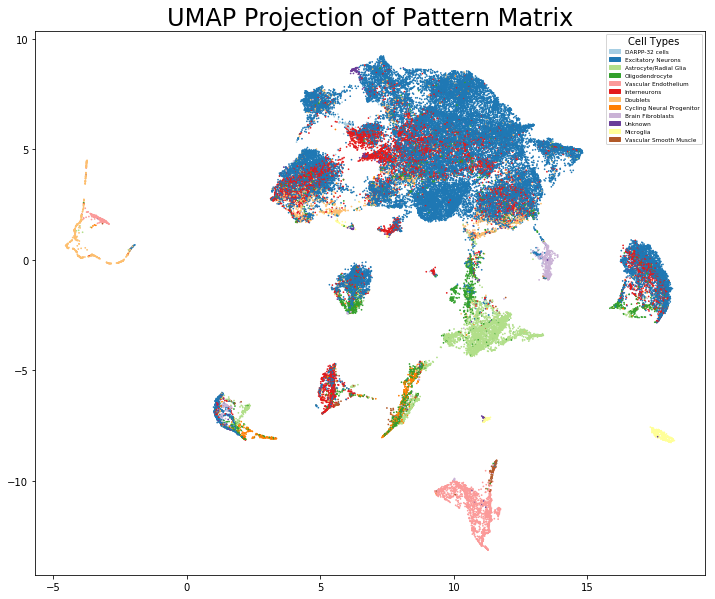

In [7]:
plt.rcParams['figure.figsize']= [12, 10]
scProject.viz.UMAP_Projection(dataset_filtered, 'CellType', 'EN60', 'UMAPEN60', 20)

Because of how scProject is set up we can use the UMAP coordinates from another regression and put new feature weights onto it this can allow the user to see how things changed on the same UMAP coordinates. Feature 20 goes to 0,

Number of nonzero cells 25498
Percentage of nonzero cells 46.04937602716223
Max coefficient 1.5915056
Average coefficient 0.20964658


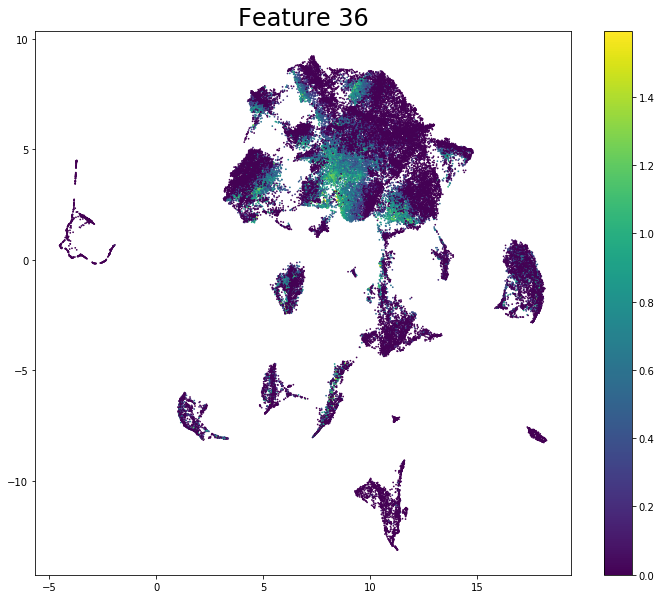

Number of nonzero cells 5454
Percentage of nonzero cells 9.849921439020425
Max coefficient 2.6409957
Average coefficient 0.039247848


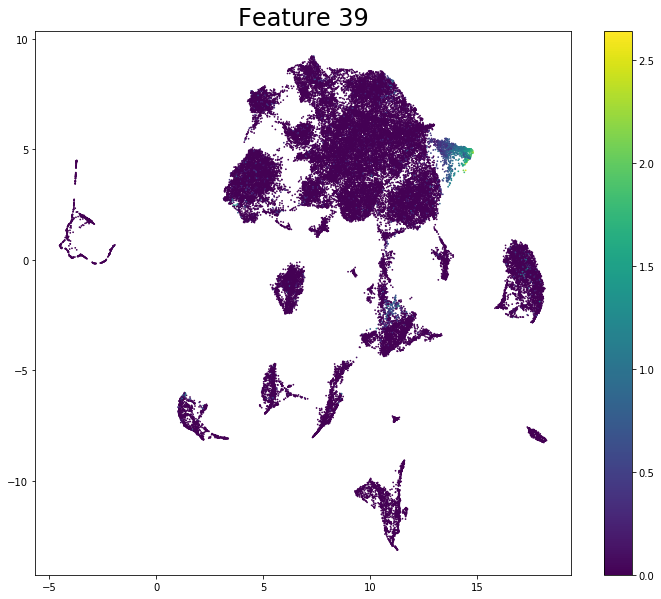

Number of nonzero cells 14400
Percentage of nonzero cells 26.00639323833776
Max coefficient 3.5692873
Average coefficient 0.14530075


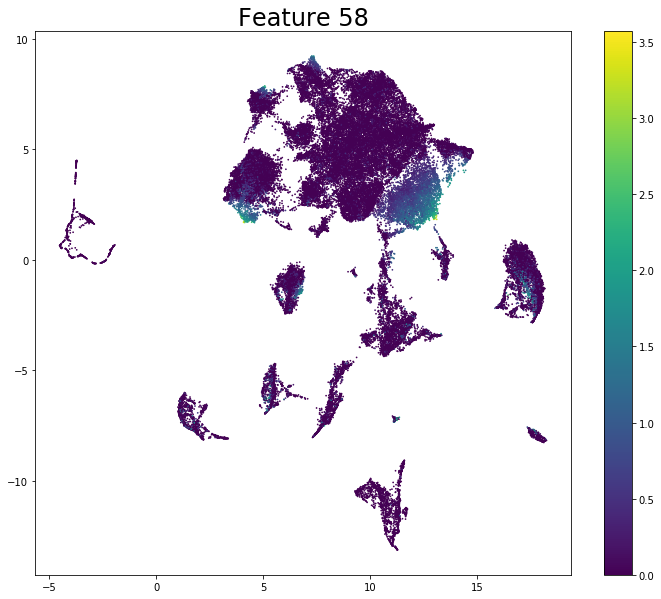

In [8]:
scProject.viz.featurePlots(dataset_filtered, [36, 39, 58], 'EN60', 'UMAPEN60')

In [9]:
print(scProject.stats.importantGenes(patterns_filtered, 36, .95))
print(scProject.stats.importantGenes(patterns_filtered, 39, .25))
print(scProject.stats.importantGenes(patterns_filtered, 58, .5))

[Index(['ENSMUSG00000086503'], dtype='object', name='index')]
[Index(['ENSMUSG00000019874', 'ENSMUSG00000041329', 'ENSMUSG00000052727',
       'ENSMUSG00000021268', 'ENSMUSG00000001270'],
      dtype='object', name='index')]
[Index(['ENSMUSG00000021939'], dtype='object', name='index')]


Now these are ensemble ids so I just used https://www.syngoportal.org/convert.html to convert them to gene names.
For Feature 36 the by far highest expressed gene is inactive X specific transcripts(Xist). This dataset is 50% male and 50% female so it would make sense that feature 36 lights up half of the clusters(the female cells).

Feature 39:
ENSMUSG00000041329	ATPase, Na+/K+ transporting, beta 2 polypeptide
ENSMUSG00000001270	creatine kinase, brain
ENSMUSG00000019874	fatty acid binding protein 7, brain
ENSMUSG00000052727	microtubule-associated protein 1B
ENSMUSG00000021268	maternally expressed 3

Feature 58:
ENSMUSG00000021939	cathepsin B 
Very sparse cathepsin B is really high.


Let's visualize the expression of the Xist gene.

Feature 36 expresses 26.545140147209167% of gene ENSMUSG00000086503


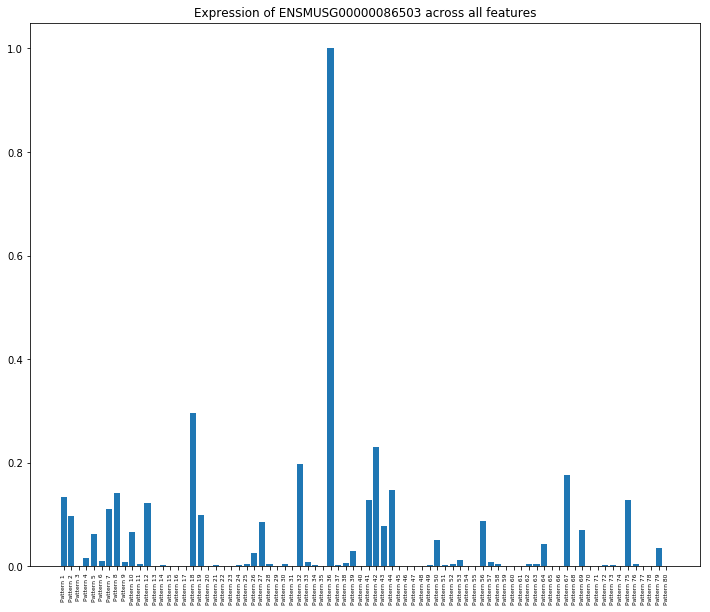

In [10]:
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000086503', 36, True)

Here we confirm that feature 36 is one of the largest "expressors" of the Xist in the retina patterns. Since feature 36 is not correlated with a specific cell type, we chose not to use the gene drivers method.